In [2]:
import numpy as np
import torch
import torchaudio
import torch.nn as nn
from IPython.display import Audio

# feel free to add more imports here

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


### Data Loading
The data consists of waveforms of audioclips sampled 8000 times per second (8 khz).
The data is stored in 16 bit precision to reduce storage size. We first need to
convert the waveforms to 32 bit precision.

In [4]:
sampling_rate = 8_000
languages = ["de", "en", "es", "fr", "nl", "pt"]
language_dict = {languages[i]: i for i in range(len(languages))}

X_train, y_train = np.load("dataset/inputs_train_fp16.npy"), np.load(
    "dataset/targets_train_int8.npy"
)
X_test, y_test = np.load("dataset/inputs_test_fp16.npy"), np.load(
    "dataset/targets_test_int8.npy"
)

X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)
y_train, y_test = y_train.astype(np.int32), y_test.astype(np.int32)


### Loader the for whole dataset

In [5]:
from torch.utils.data import DataLoader, TensorDataset
BATCH_SIZE = 64
data_train = TensorDataset( torch.Tensor(X_train), torch.Tensor(y_train) )
data_test = TensorDataset( torch.Tensor(X_test),torch.Tensor(y_test))

train_loader = torch.utils.data.DataLoader(data_train,batch_size=BATCH_SIZE,shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test,batch_size=BATCH_SIZE,shuffle=True)

In [6]:
print(next(enumerate(train_loader))[1][0].shape)

torch.Size([64, 40000])


### Subset dataset to EN and ES only

In [7]:
from torch.utils.data import DataLoader, TensorDataset

#creating boolean mask to subset dataset
mask_train = np.logical_or(y_train == language_dict["en"], y_train == language_dict["es"])
mask_test = np.logical_or(y_test == language_dict["en"], y_test == language_dict["es"])
#subset dataset based on boolean mask
X_train_en_es = X_train[mask_train]
y_train_en_es = y_train[mask_train]
X_test_en_es = X_test[mask_test]
y_test_en_es = y_test[mask_test]
#new target values
y_train_en_es = np.where(y_train_en_es == language_dict["en"], 0, 1)
y_test_en_es = np.where(y_test_en_es == language_dict["en"], 0, 1)

print(X_train_en_es.shape)
print(y_train_en_es.shape)
X_train_en_es = TensorDataset( torch.Tensor(X_train_en_es), torch.Tensor(y_train_en_es) )
X_test_en_es = TensorDataset( torch.Tensor(X_test_en_es),torch.Tensor(y_test_en_es))


(2000, 40000)
(2000,)


### Loader for subset dataset

In [8]:
BATCH_SIZE = 64

train_en_es_loader = torch.utils.data.DataLoader(X_train_en_es,batch_size=BATCH_SIZE,shuffle=True)
test_en_es_loader = torch.utils.data.DataLoader(X_test_en_es,batch_size=BATCH_SIZE,shuffle=True)



In [9]:
a = next(enumerate(train_en_es_loader))
print(a[1][0].shape)

torch.Size([64, 40000])


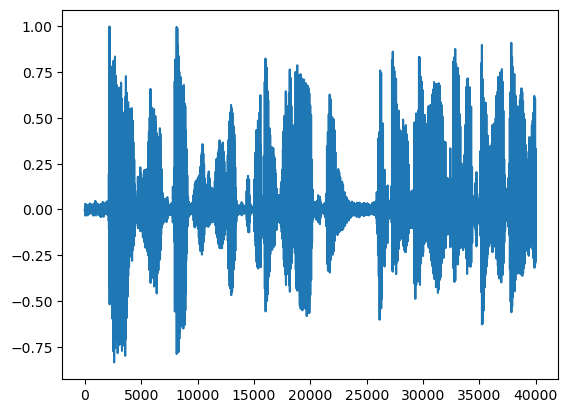

In [10]:
import matplotlib.pyplot as plt
selected_language = "nl"
idxs = np.where(y_train == language_dict[selected_language])[0]
idx = np.random.choice(idxs)

signal = torch.tensor(X_train[idx])
max = torch.max(torch.abs(signal),0,True).values
signal = signal / max
signal = torch.clip(signal,-1,1)

#Audio(y,rate=sampling_rate)

times = np.linspace(0, 40000, num=40000)
plt.plot(times,signal)



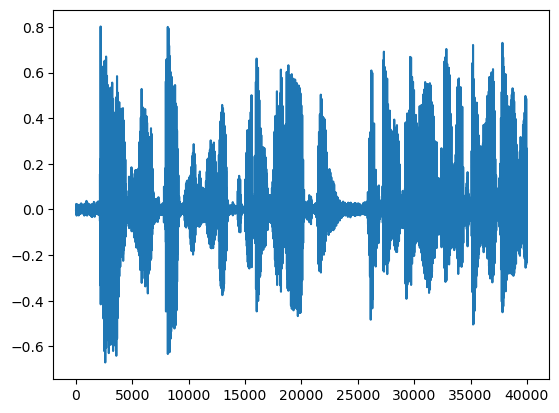

In [11]:
Audio(X_train[idx], rate=sampling_rate)
plt.plot(times,X_train[idx])

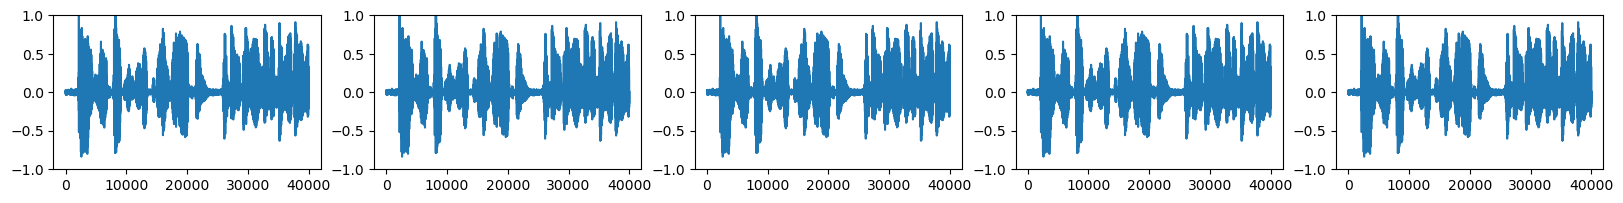

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(20,2))
times = np.linspace(0, 40000, num=40000)
plt.setp(ax, ylim=(-1,1))

for i in range(5):
    idxs = np.random.choice(y_train)
    signal = torch.tensor(X_train[idx])
    max = torch.max(torch.abs(signal),0,True).values
    signal = signal / max
    signal = torch.clip(signal,-1,1)
    ax[i].plot(times,signal)




### Normalization around mean and standard deviation values. So all means and std were between 0 and 1


In [14]:
class ExampleNormalization(nn.Module):
    def __init__(self, sampling_rate):
        super().__init__()
        self.register_buffer("sampling_rate",torch.tensor(sampling_rate))
        self.register_buffer("n_fft",torch.tensor(2 ** (sampling_rate // 1000 * 10).bit_length()))
        self.register_buffer("hop_length",self.n_fft // 4)
        self.spectrogram = torchaudio.transforms.Spectrogram(n_fft=self.n_fft, hop_length=self.hop_length)
        self.spectrogram_db = torchaudio.transforms.AmplitudeToDB()

    def forward(self, x):
        # torch no_grad is used since we don't want to save the gradient
        # for the pre-processing steps
        with torch.no_grad():
            # we multiply the input by the constant
            max_amplitude = torch.max(torch.abs(x),2,keepdim=True).values
            normalized_x = x / max_amplitude
            # Convert the audio to a spectrogram
            spectrogram = self.spectrogram(normalized_x)
            # Convert the spectrogram to a decibel-scaled spectrogram
            spectrogram_db = self.spectrogram_db(spectrogram)

            # Normalize the spectrogram to have a mean of 0 and a standard deviation of 1

            spectrogram_normalized = (spectrogram_db - spectrogram_db.mean()) / spectrogram_db.std()

            # Convert the spectrogram back to a PyTorch tensor
            #spectrogram_normalized = spectrogram_normalized.unsqueeze(0)

            return spectrogram_normalized

example_normalization = ExampleNormalization(8000)

### Audio signal 2d normalization

### Transform audio waveform into spectrogram and normalize it

In [16]:
class ResModel(nn.Module):
    def __init__(self):
        super(ResModel,self).__init__()

        self.Norm = example_normalization
        self.Conv_1 = nn.Conv2d(1,32,(3,3),padding=1)
        self.BatchNorm_1 = nn.BatchNorm2d(32)
        self.Conv_11 = nn.Conv2d(1,32,(1,1))
        self.BatchNorm_11 = nn.BatchNorm2d(32)
        self.ReLU_1 = nn.ReLU()
        self.MaxPool_1 = nn.MaxPool2d(kernel_size=3)

        self.Conv_2 = nn.Conv2d(32,64,(3,3),padding=1)
        self.BatchNorm_2 = nn.BatchNorm2d(64)
        self.Conv_21 = nn.Conv2d(32,64,(1,1))
        self.BatchNorm_21 = nn.BatchNorm2d(64)
        self.ReLU_2 = nn.ReLU()
        self.MaxPool_2 = nn.MaxPool2d(kernel_size=3)

        self.Conv_3 = nn.Conv2d(64,64,(3,3),padding=1)
        self.BatchNorm_3 = nn.BatchNorm2d(64)
        self.Conv_31 = nn.Conv2d(64,64,(1,1))
        self.BatchNorm_31 = nn.BatchNorm2d(64)
        self.ReLU_3 = nn.ReLU()
        self.MaxPool_3 = nn.MaxPool2d(kernel_size=3)

        self.Conv_4 = nn.Conv2d(64,128,(3,3),padding=1)
        self.BatchNorm_4 = nn.BatchNorm2d(128)
        self.Conv_41 = nn.Conv2d(64,128,(1,1))
        self.BatchNorm_41 = nn.BatchNorm2d(128)
        self.ReLU_4 = nn.ReLU()
        self.MaxPool_4 = nn.MaxPool2d(kernel_size=3)

        self.Conv_5 = nn.Conv2d(128,128,(3,3),padding=1)
        self.BatchNorm_5 = nn.BatchNorm2d(128)
        self.Conv_51 = nn.Conv2d(128,128,(1,1))
        self.BatchNorm_51 = nn.BatchNorm2d(128)
        self.ReLU_5 = nn.ReLU()

        self.Flatten = nn.Flatten()

        self.Linear_1 = nn.Linear(128*2*46,32,bias=True) # 128*156 if all pool kernel == 2
        self.BatchNorm_L1 = nn.BatchNorm1d(32)
        self.Drop_1 = nn.Dropout(0.5)
        self.ReLU_L_1 = nn.ReLU()

        self.Linear_2 = nn.Linear(32,6,True)
        self.Out_activation = nn.Softmax(-1)

    def forward(self,inputs):
        norm = self.Norm(inputs)

        c1 = self.Conv_1(norm)
        c1 = self.BatchNorm_1(c1)
        input_1x1 = self.Conv_11(norm)
        input_1x1 = self.BatchNorm_11(input_1x1)
        r1 = self.ReLU_1(c1 + input_1x1)
        m1 = self.MaxPool_1(r1)

        c2 = self.Conv_2(m1)
        c2 = self.BatchNorm_2(c2)
        m1_1x1 = self.Conv_21(m1)
        m1_1x1 = self.BatchNorm_21(m1_1x1)
        r2 = self.ReLU_2(c2 + m1_1x1)
        m2 = self.MaxPool_2(r2)

        c3 = self.Conv_3(m2)
        c3 = self.BatchNorm_3(c3)
        m2_1x1 = self.Conv_31(m2)
        m2_1x1 = self.BatchNorm_31(m2_1x1)
        r3 = self.ReLU_3(c3 + m2_1x1)
        m3 = self.MaxPool_3(r3)

        c4 = self.Conv_4(m3)
        c4 = self.BatchNorm_4(c4)
        m3_1x1 = self.Conv_41(m3)
        m3_1x1 = self.BatchNorm_41(m3_1x1)
        r4 = self.ReLU_4(c4 + m3_1x1)

        c5 = self.Conv_5(r4)
        c5 = self.BatchNorm_5(c5)
        r4_1x1 = self.Conv_51(r4)
        r4_1x1 = self.BatchNorm_51(r4_1x1)
        r5 = self.ReLU_5(c5 + r4_1x1)

        x = self.Flatten(r5)
        x = self.Linear_1(x)
        x = self.BatchNorm_L1(x)
        x = self.Drop_1(x)
        x = self.ReLU_L_1(x)

        x = self.Linear_2(x)
        x = self.Out_activation(x)

        return x


res2model = ResModel().to(device)


# Training multi-classification model

In [17]:
from torch import optim
signals = None
def multi_train_model(model,train_en_es_loader,test_en_es_loader):
    optimizer = optim.Adam(model.parameters(),lr=0.003)
    crossentropy_loss = nn.CrossEntropyLoss()
    num_epochs = 40
    model.train()
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []
    y_pred = []
    y_true = []
    model_outputs_test = []

    for epoch in range(num_epochs):
        model.train()
        print('Currently training epoch {} of {}'.format(epoch, num_epochs))


        running_train_acc = 0
        running_train_loss = 0

        running_test_acc = 0
        running_test_loss = 0
        for signals,labels in train_en_es_loader:
            signals = signals.to(device)
            labels = labels.to(device).byte()
            optimizer.zero_grad()
            predictions = model(signals)

            train_accuracy = (torch.max(predictions,dim=1,keepdim=True)[1].flatten() == labels).sum() / len(labels)
            loss = crossentropy_loss(predictions,labels)

            running_train_acc += train_accuracy.item()
            running_train_loss += float(loss)

            loss.backward()
            optimizer.step()

        train_acc = running_train_acc / len(train_en_es_loader)

        train_loss = running_train_loss / len(train_en_es_loader)

        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)

        signals = None
        model.eval()
        with torch.no_grad():
            for signals, labels in test_en_es_loader:
                signals = signals.to(device)
                labels = labels.to(device).byte()
                predictions = model(signals)
                test_accuracy = (torch.max(predictions,dim=1,keepdim=True)[1].flatten() == labels).sum() / len(labels)
                test_loss = crossentropy_loss(predictions,labels)
                #print((torch.max(predictions,dim=1,keepdim=True)[1]).shape )
                #print((torch.max(torch.exp(predictions), 1)[1]).shape)
                output = (torch.max(torch.exp(predictions),1)[1]).data.cpu().numpy()
                y_pred.extend(output)

                y_true.extend(labels.data.cpu().numpy())
                model_outputs_test.extend(predictions.data.cpu().numpy())
                running_test_acc += test_accuracy.item()
                running_test_loss += float(test_loss)


            test_acc = running_test_acc / len(test_en_es_loader)
            test_loss = running_test_loss / len(test_en_es_loader)
            test_acc_history.append(test_acc)
            test_loss_history.append(test_loss)
        print(f"Accuracy on train set is {train_acc} and on Test set is {test_acc}")
    return train_loss_history , test_loss_history,train_acc_history,test_acc_history, y_true, y_pred, model_outputs_test



train_loss_history , test_loss_history,train_acc_history,test_acc_history, y_true, y_pred, model_outputs_test = multi_train_model(res2model,train_loader,test_loader)

Currently training epoch 0 of 40


MIOpen(HIP): Warning [SQLiteBase] Missing system database file: gfx1030_20.kdb Performance may degrade. Please follow instructions to install: https://github.com/ROCmSoftwarePlatform/MIOpen#installing-miopen-kernels-package


Accuracy on train set is 0.3371010638297872 and on Test set is 0.3078399128035495
Currently training epoch 1 of 40
Accuracy on train set is 0.4881427307078179 and on Test set is 0.33662280754039164
Currently training epoch 2 of 40
Accuracy on train set is 0.5818927307078179 and on Test set is 0.42050438648776006
Currently training epoch 3 of 40
Accuracy on train set is 0.6481050531914894 and on Test set is 0.4868421052631579
Currently training epoch 4 of 40
Accuracy on train set is 0.694813829787234 and on Test set is 0.608826756477356
Currently training epoch 5 of 40
Accuracy on train set is 0.7208554966652647 and on Test set is 0.5117872827931454
Currently training epoch 6 of 40
Accuracy on train set is 0.7738807626227115 and on Test set is 0.5093201775299875
Currently training epoch 7 of 40
Accuracy on train set is 0.8062389188624443 and on Test set is 0.32373903534914317
Currently training epoch 8 of 40
Accuracy on train set is 0.8270168443943592 and on Test set is 0.64336623016156

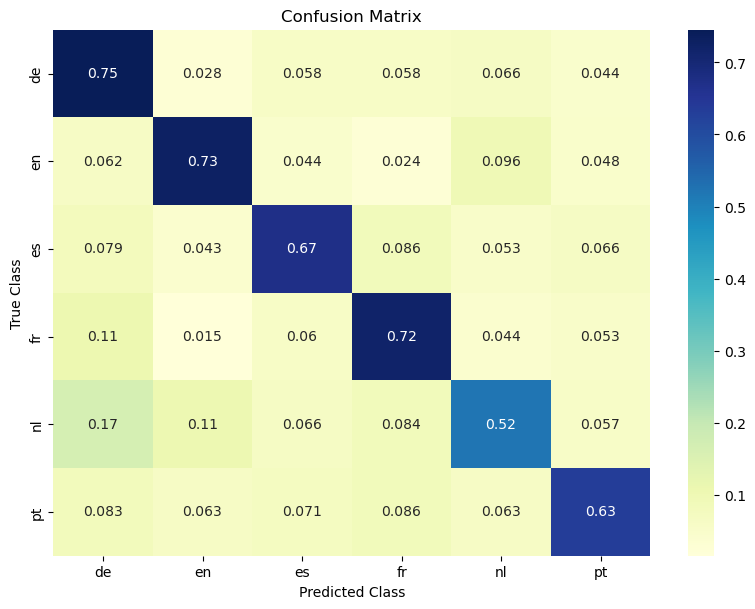

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
index = [i for i in language_dict],
columns = [i for i in language_dict])
plt.figure(figsize = (8,6))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"),
plt.xlabel("Predicted Class")
plt.show()

# Plot loss of train and test dataset


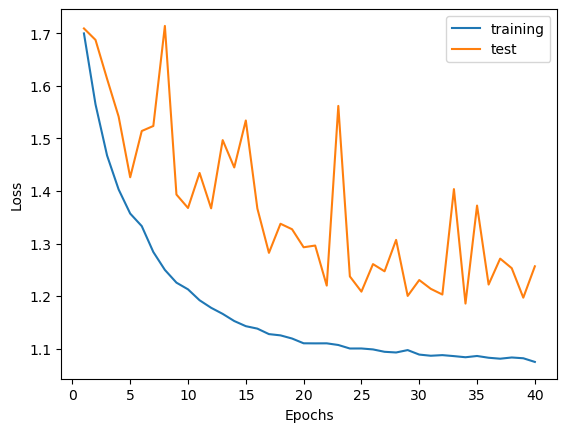

In [29]:
plt.plot(range(1,len(train_loss_history) +1), train_loss_history)
plt.plot(range(1,len(test_loss_history) +1), test_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training","test"])
plt.show()


# Plot accuracy of train and test dataset


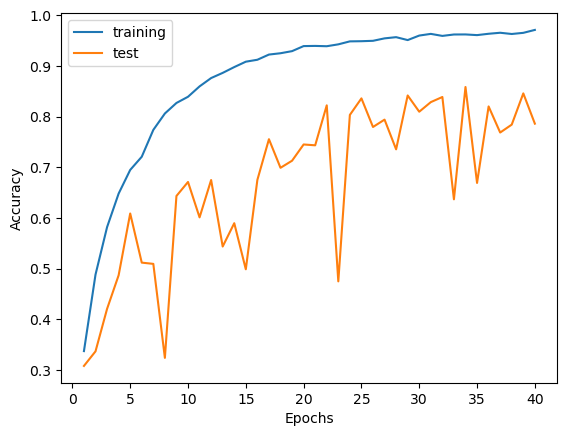

In [30]:
import matplotlib.pyplot as plt


plt.plot(range(1,len(train_acc_history) +1), train_acc_history)
plt.plot(range(1,len(test_acc_history) +1), test_acc_history)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["training","test"])
plt.show()

### Making a PCA plot of the output space

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [34]:
model_outputs = torch.randn(1200, 6)

targets = torch.randint(0, 6, (1200,))

In [35]:
outputs_PCA = PCA(n_components=2).fit_transform(model_outputs)

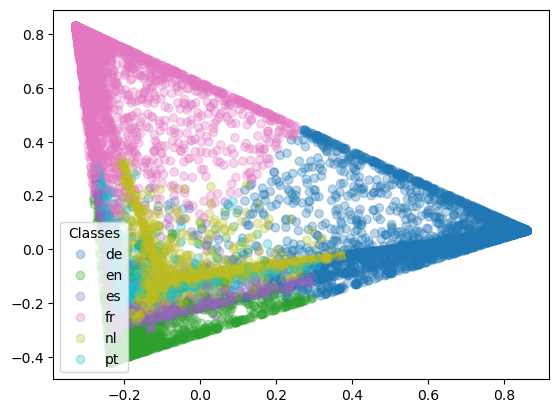

In [36]:
from sklearn.decomposition import PCA
outputs_PCA_test = PCA(n_components=2).fit_transform(model_outputs_test)
fig, ax = plt.subplots()
scatter = ax.scatter(*outputs_PCA_test.T, c=y_pred, cmap="tab10", alpha=0.3)
legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
for i, text in enumerate(legend.get_texts()):
    text.set_text(languages[i])